In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import interpolation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
filled_1850 = pd.read_csv("../data/dwelling_filled_sum_1850_mn.csv")
census_1880 = pd.read_csv("../data/census_1880_mn_blocks.csv")
cd_1850 = pd.read_csv("../data/cd_1850_XYupdate.csv")
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"Ward_Num", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_RACE":"CENSUS_RACEB", "CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)
filled_1850.dropna(subset = ["block_num"], inplace = True)

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print("Number of Blocks in Each Ward, disambiguation")
for ward, df in filled_1850.groupby(["Ward_Num"]):
    print("Ward ",ward,": ", df.block_num.nunique(), sep = "")

Number of Blocks in Each Ward, disambiguation
Ward 1: 68
Ward 2: 38
Ward 3: 38
Ward 4: 45
Ward 5: 74
Ward 6: 42
Ward 7: 71
Ward 8: 61
Ward 9: 103
Ward 10: 45
Ward 11: 49
Ward 13: 46
Ward 14: 38
Ward 15: 70
Ward 16: 74
Ward 17: 64
Ward 18: 87
Ward 19: 3


In [6]:
print("Number of Blocks in Each Ward, city directory")
for ward, df in cd_1850.groupby(["Ward_Num"]):
    print("Ward ",ward,": ", df.block_num.nunique(), sep = "")

Number of Blocks in Each Ward, city directory
Ward 1.0: 82
Ward 2.0: 49
Ward 3.0: 43
Ward 4.0: 49
Ward 5.0: 76
Ward 6.0: 45
Ward 7.0: 72
Ward 8.0: 63
Ward 9.0: 112
Ward 10.0: 45
Ward 11.0: 52
Ward 13.0: 47
Ward 14.0: 40
Ward 15.0: 75
Ward 16.0: 94
Ward 17.0: 70
Ward 18.0: 116
Ward 19.0: 15


In [8]:
print("Percentage of blocks represented present in disambiguation")
for dis, cd in zip(filled_1850.groupby(["Ward_Num"]), cd_1850.groupby(["Ward_Num"])):
    print("Ward ",dis[0],": ", round(dis[1].block_num.nunique()/cd[1].block_num.nunique(), 2), sep = "")

Percentage of blocks represented present in disambiguation
Ward 1: 0.83
Ward 2: 0.78
Ward 3: 0.88
Ward 4: 0.92
Ward 5: 0.97
Ward 6: 0.93
Ward 7: 0.99
Ward 8: 0.97
Ward 9: 0.92
Ward 10: 1.0
Ward 11: 0.94
Ward 13: 0.98
Ward 14: 0.95
Ward 15: 0.93
Ward 16: 0.79
Ward 17: 0.91
Ward 18: 0.75
Ward 19: 0.2


That's not as terrible as I was expecting, apart from Ward 19, which was definitely going to be pretty terrible. I do think it's interesting that we have so few matches in that ward

In [10]:
#This is a bit of a side note, but I never thought to look at the match rate on the ward
#level
filled_1850_all = pd.read_csv("../data/dwelling_filled_sum_1850_mn.csv")
print("Disambiguation census record match rate per ward, 1850")
for ward, df in filled_1850_all.groupby(["CENSUS_WARD_NUM"]):
    print("Ward ",ward,": ", round(df.CD_ADDRESS.count()/len(df), 4), sep = "")

Disambiguation census record match rate per ward, 1850
Ward 1: 0.6838
Ward 2: 0.4356
Ward 3: 0.2701
Ward 4: 0.57
Ward 5: 0.5611
Ward 6: 0.4976
Ward 7: 0.5974
Ward 8: 0.6874
Ward 9: 0.6934
Ward 10: 0.4028
Ward 11: 0.3895
Ward 12: 0.0
Ward 13: 0.6312
Ward 14: 0.6062
Ward 15: 0.3815
Ward 16: 0.5889
Ward 17: 0.5286
Ward 18: 0.3152
Ward 19: 0.0031


That's pretty interesting, I didn't realize that Ward 12 had no matches whatsoever. This ward level distribution may be worth exploring in more depth. So the reason for that is that there are no records for ward 12 in the city directory data

In [11]:
dwellings_1850_all = filled_1850_all.groupby(["CENSUS_WARD_NUM", "CENSUS_DWELLING_NUM"], as_index = False).first()
print("Disambiguation dwelling match rate per ward, 1850")
for ward, df in dwellings_1850_all.groupby(["CENSUS_WARD_NUM"]):
    print("Ward ",ward,": ", round(df.CD_ADDRESS.count()/len(df),4), sep = "")

Disambiguation dwelling match rate per ward, 1850
Ward 1: 0.5234
Ward 2: 0.2476
Ward 3: 0.1865
Ward 4: 0.4539
Ward 5: 0.4932
Ward 6: 0.4248
Ward 7: 0.5181
Ward 8: 0.6195
Ward 9: 0.6081
Ward 10: 0.3631
Ward 11: 0.3139
Ward 12: 0.0
Ward 13: 0.573
Ward 14: 0.4941
Ward 15: 0.353
Ward 16: 0.4608
Ward 17: 0.4369
Ward 18: 0.2437
Ward 19: 0.0017


In [29]:
#let's try constructing a centroid for each block based on the city directory,
#with the goal of using that in the loss function for the block number prediction model
#And hopefully help with avoiding bias?

In [12]:
cd_1850.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31844 entries, 0 to 31843
Data columns (total 24 columns):
OBJECTID      31844 non-null int64
Join_Count    31844 non-null int64
TARGET_FID    31844 non-null int64
Join_Cou_1    31844 non-null int64
TARGET_F_1    31844 non-null int64
id            31844 non-null object
type          31844 non-null object
name          31824 non-null object
F__data_pa    31844 non-null int64
F__data_te    31844 non-null object
F__data_oc    30472 non-null object
cd_full_na    31824 non-null object
cd_first_n    31824 non-null object
cd_last_na    31776 non-null object
cd_full__1    31824 non-null object
cd_full_re    31844 non-null object
cd_occupat    30472 non-null object
cd_addr       31844 non-null object
street_add    31844 non-null object
street_nam    31844 non-null object
Ward_Num      31762 non-null float64
block_num     31844 non-null int64
cd_X          31844 non-null float64
cd_Y          31844 non-null float64
dtypes: float64(3), int64(7), o

In [15]:
#I'm going to do this as a dictionary of dictionaries because we really to use
#this information in other forms
def make_centroid(x,y):
    return(sum(x)/len(x), sum(y)/len(y))

In [16]:
block_centroids = {ward:{block:make_centroid(df_block.cd_X, df_block.cd_Y) for block, df_block in df.groupby("block_num")} for ward,df in cd_1850.groupby(["Ward_Num"])}

In [1]:
for key in block_centroids.keys():
    plt.scatter([value[0] for value in block_centroids[key].values()], [value[1] for value in block_centroids[key].values()], label = key, s = 5)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()
plt.title("Block Centroids by Ward, 1850")
plt.show()

NameError: name 'block_centroids' is not defined

Now there are two aspects left of this, one is to construct bins (I think I'll do this first) the next is to change the loss function of the model we use to best accomodate this revision.

### Binning blocks based on centroid

Concept: Currently, we have a situation where we don't have a lot of data for blocks, either in the city directory or in the disambiguation output. For example, there are some blocks with only one record. By binning the data we'll hopefully be able to label records with some level of geographical location and a much greater level of accuracy. Hopefully afterwards, work can be done to narrow things down further. The goal of this work is to give most dwellings in 1850 some level of geographic location within wards.

Some things to keep in mind:
- Wards are different, there will be some wards where we can assign geographic locations with much greater granularity than others
- Wards are shaped differently, this might mean something in what binning looks like
- Centroids may mean different things depending on what a block looks like (this is something I think it's important to get a sense of first)

#### Sanity check what centroids represent
-Let's select some blocks and look at the location of the centroid in comparison to all the points within them

In [61]:
def centroid_vis(ward, block, centroid, cd):
    plt.scatter(centroid[ward][block][0],centroid[ward][block][1], label = "centroid", s = 10)
    df = cd[(cd["Ward_Num"] == ward) & (cd["block_num"] == block)]
    plt.scatter(df.cd_X, df.cd_Y, label = "block", alpha = 0.5, s = 5)
    plt.legend()
    plt.title("Centroid and known dwellings Ward "+str(ward)+ " Block "+ str(block)+", 1850")
    plt.tight_layout()
    plt.show()
    print("Total known dwellings in block:", len(df))

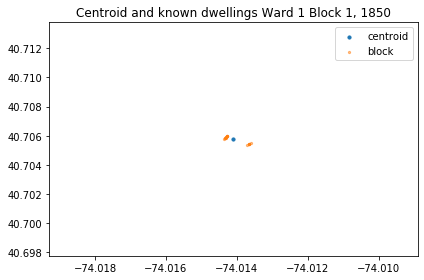

Total known dwellings in block: 19


In [62]:
centroid_vis(1, 1, block_centroids, cd_1850)

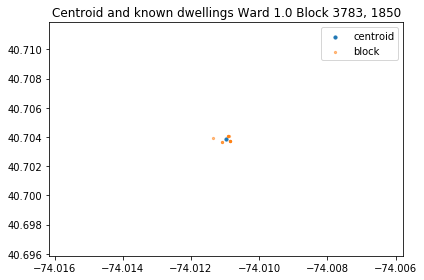

Total known dwellings in block: 11


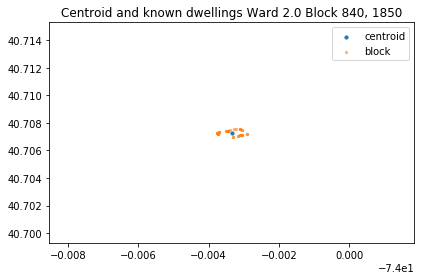

Total known dwellings in block: 36


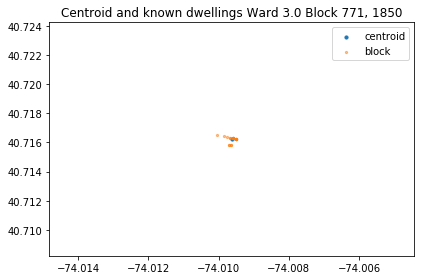

Total known dwellings in block: 23


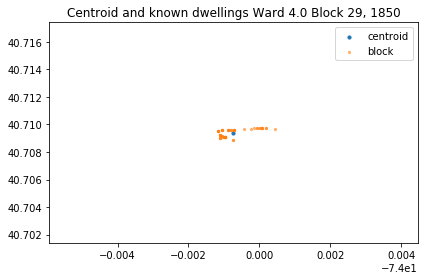

Total known dwellings in block: 53


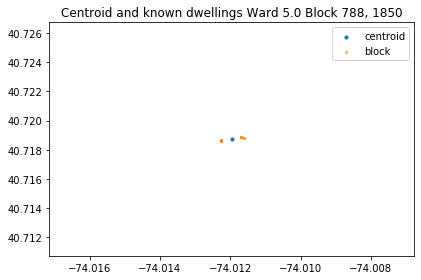

Total known dwellings in block: 10


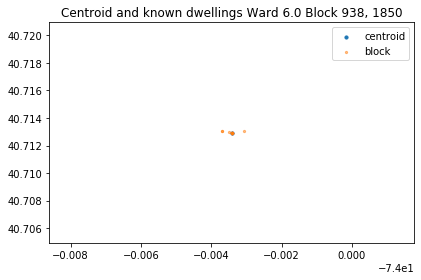

Total known dwellings in block: 20


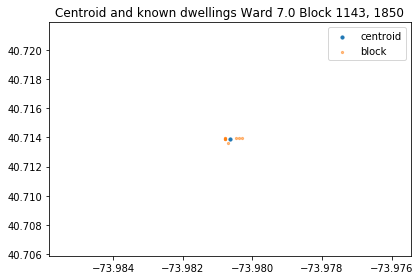

Total known dwellings in block: 9


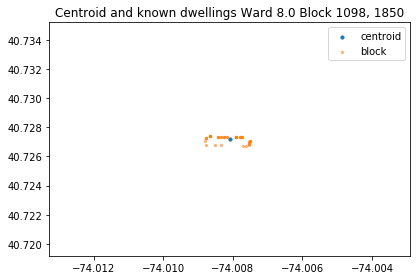

Total known dwellings in block: 45


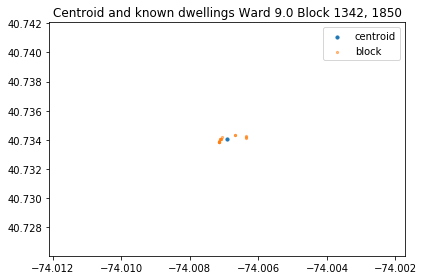

Total known dwellings in block: 15


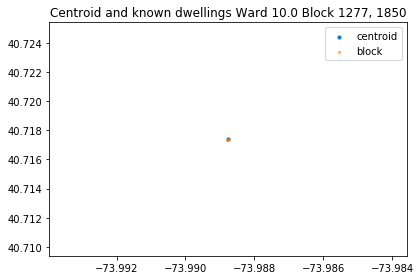

Total known dwellings in block: 2


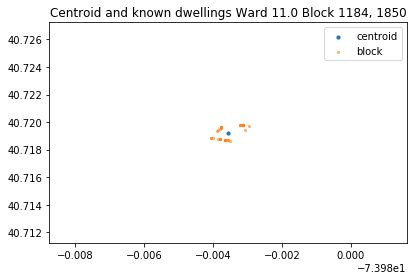

Total known dwellings in block: 31


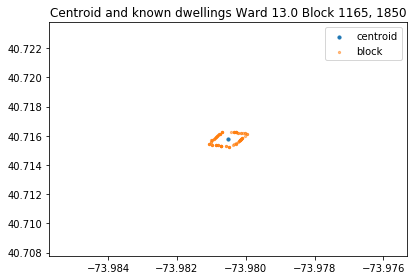

Total known dwellings in block: 99


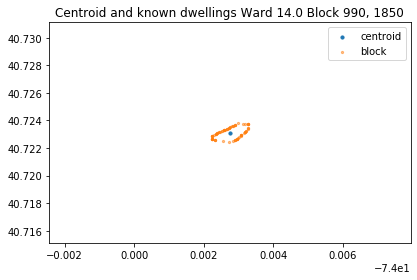

Total known dwellings in block: 76


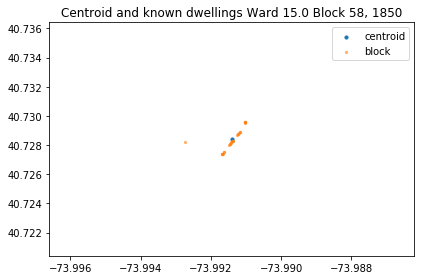

Total known dwellings in block: 26


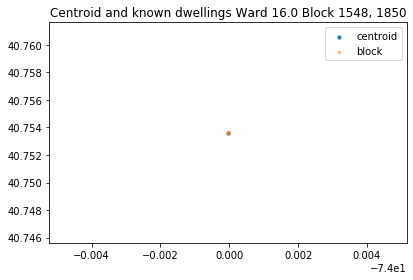

Total known dwellings in block: 3


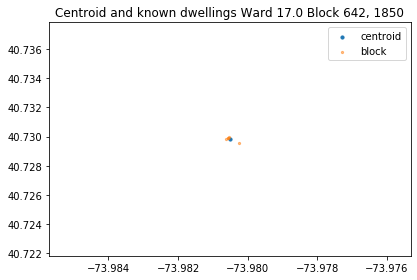

Total known dwellings in block: 5


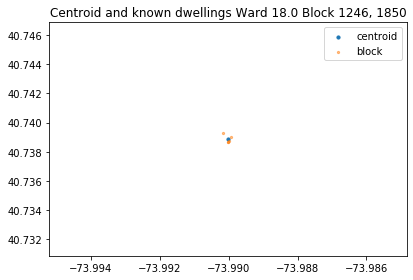

Total known dwellings in block: 5


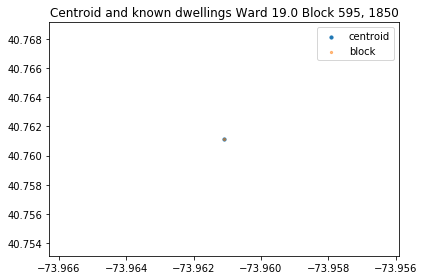

Total known dwellings in block: 1


In [63]:
for ward in block_centroids.keys():
    block = np.random.choice(cd_1850[cd_1850["Ward_Num"] == ward].block_num.unique())
    centroid_vis(ward, block, block_centroids, cd_1850)

The sanity check holds, in that the centroid appears to be pretty representative of the geographical location of the block, that is, it doesn't look like there are any outliers or unexpected outcomes from what we've done (which is as expected given how blocks are defined)

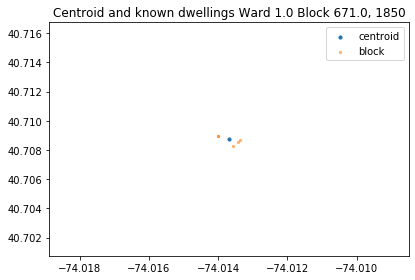

Total known dwellings in block: 5


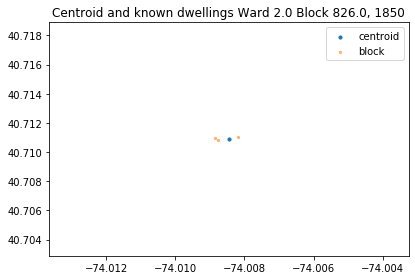

Total known dwellings in block: 3


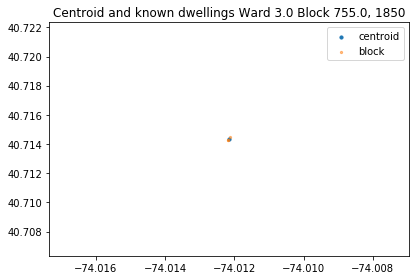

Total known dwellings in block: 3


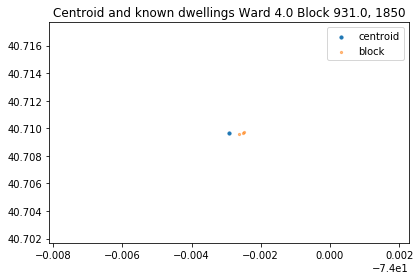

Total known dwellings in block: 3


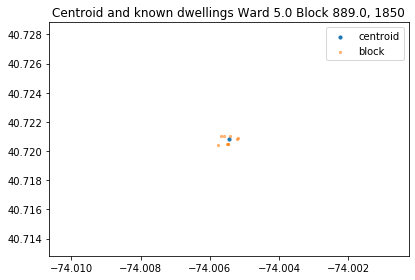

Total known dwellings in block: 9


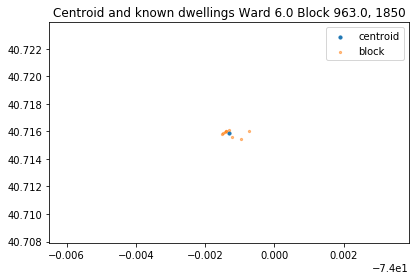

Total known dwellings in block: 9


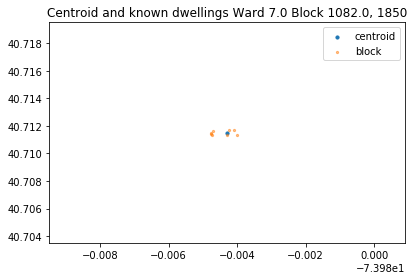

Total known dwellings in block: 8


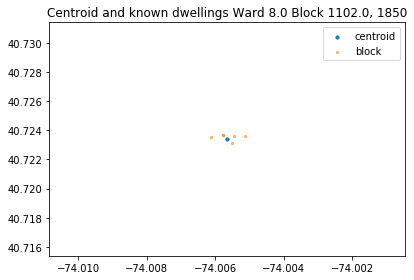

Total known dwellings in block: 6


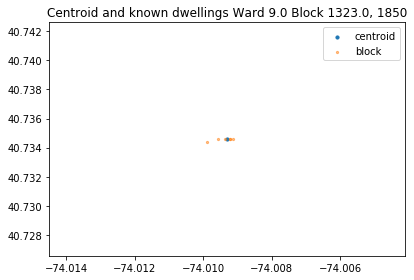

Total known dwellings in block: 6


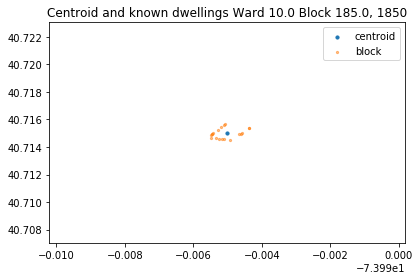

Total known dwellings in block: 19


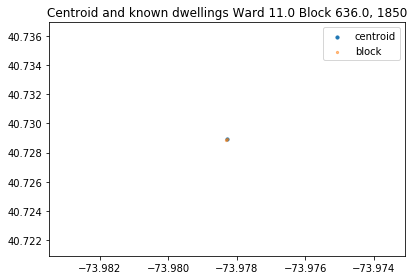

Total known dwellings in block: 2


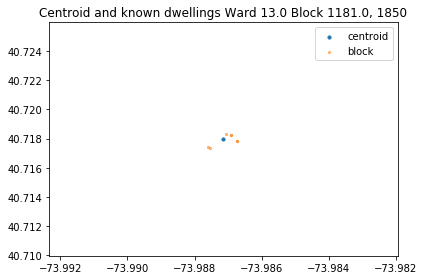

Total known dwellings in block: 7


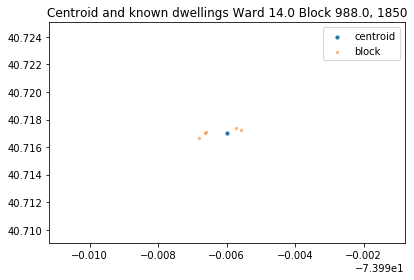

Total known dwellings in block: 5


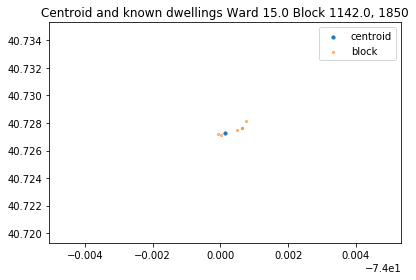

Total known dwellings in block: 6


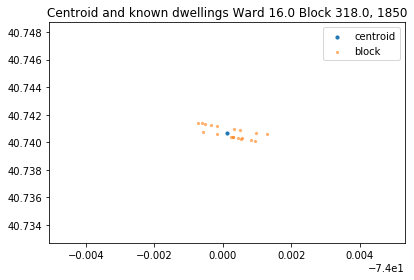

Total known dwellings in block: 19


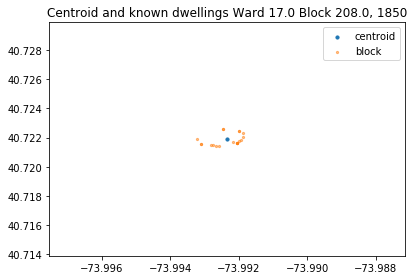

Total known dwellings in block: 20


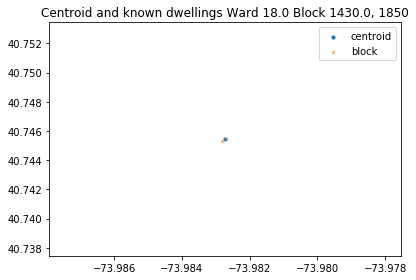

Total known dwellings in block: 2


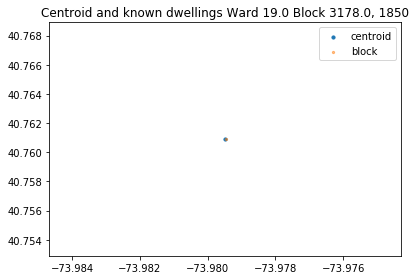

Total known dwellings in block: 1


In [69]:
#Let's do the same thing, but look at the centroid and the values that we actually
#have in the data
dwellings_1850 = filled_1850.groupby(["Ward_Num", "CENSUS_DWELLING_NUM"], as_index = False).first()
for ward in block_centroids.keys():
    block = np.random.choice(dwellings_1850[dwellings_1850["Ward_Num"] == ward].block_num.unique())
    centroid_vis(ward, block, block_centroids, dwellings_1850)

This also seems to support the idea that centroids will work reasonably even though all blocks/missing points aren't represented within the disambiguation

#### Binning approaches
The most obvious approach is clustering let's look at a few clustering approaches that may make sense here

Things to keep in mind:
- Our true goal is to create clusters of centroids (really blocks) that have as much data as possible while incorporating as few blocks as possible to provide as much granularity as we can
- That being said, starting with larger clusters may not be a bad idea

Clustering Algorithms:
- Kmeans: centroid based clusters (tune number of clusters)
- Hierarchical: clusters based on hierarchical structure
- Density based: clusters areas of high density (tune epsilon, number of neighbors)

Because the blocks themselves don't really have a hierarichical structure within wards,  kmeans or a density based algorithm (hdbscan) makes the most sense

Could we consider/explore clustering the data itself?
- a little hesitant because guaging how useful any potential cluster would be is more difficult here I think?

Should the clustering happen on the city directory data or the census data?
- Let's start with the city directory data for clustering so that clusters that don't show up in the disambiguation are part of the clustering

##### Kmeans

In [10]:
from sklearn.cluster import KMeans

In [11]:
def apply_clustering(df, ward, block_centroids, algo, name = "cluster"): 
    
    clusters = algo.fit_predict(np.array(list(block_centroids[ward].values())))
    block_cluster_map = {block:clust for block, clust in zip(block_centroids[ward].keys(), clusters)}
    
    return(clusters, block_cluster_map)


In [12]:
def cluster_mapping(df, block_cluster_map, name = "cluster"):
    df[name] = df.apply(lambda row: block_cluster_map[row["block_num"]], axis = 1)

In [13]:
def clustervis(df, ward, clusters, block_cluster_map, block_centroids, algo = None, name = "cluster", title = None):
    colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][x] for x in range(len(np.unique(clusters)))]
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    
    for cluster, color in zip(np.unique(clusters), colors):
        #get cluster data
        X_subset = df[df[name] == cluster]
        centroids_subset = np.array(list(block_centroids[ward].values()))[clusters == cluster]
        
        #graph info
        ax.scatter(x = X_subset.loc[:,"cd_X"], y = X_subset.loc[:,"cd_Y"], s=5, alpha =0.8, label = str(cluster), color = color)
        ax.scatter(centroids_subset[:,0], centroids_subset[:,1], marker = "*", s = 80, color = color)
        if title is not None: 
            ax.set_title(title)
        else:
            ax.set_title("Clustered blocks, Ward " + str(ward)+ ", 1850")
        
    #ax.scatter([value[0] for value in block_centroids[ward].values()], [value[1] for value in block_centroids[ward].values()], marker = "*", label = "block centroids", s = 80, c = "k")
    if (algo is not None): 
        ax.scatter(x = algo.cluster_centers_[:,0], y = algo.cluster_centers_[:,1], marker ="x", c="k", s = 50, label = "cluster centroids")
    
    ax.legend()

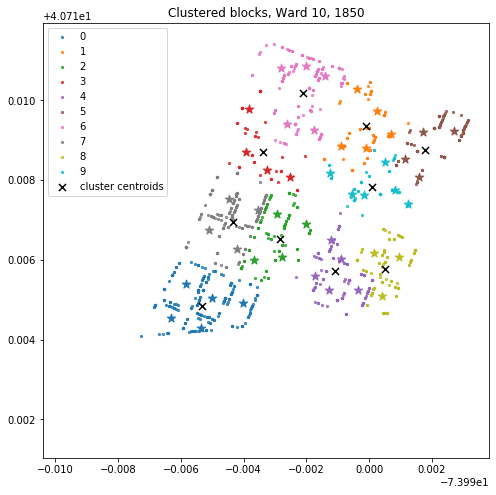

In [17]:
#let's look at ward 10
ward = 10
algo = KMeans(10)
cd_1850_10 = cd_1850[cd_1850["Ward_Num"] == ward].copy()

clusters, block_cluster_map = apply_clustering(cd_1850_10, ward, block_centroids, algo)
cluster_mapping(cd_1850_10, block_cluster_map)
clustervis(cd_1850_10, ward, clusters, block_cluster_map, block_centroids, algo = algo)

In [253]:
cd_1850_10.cluster.value_counts()

2    298
4    217
1    207
3    187
5    146
0     68
Name: cluster, dtype: int64

In [254]:
print("cluster, count")
for cluster, count in zip(np.unique(clusters, return_counts = True)[0], np.unique(clusters, return_counts = True)[1]):
    print(cluster, ": ", count, sep = "")

cluster, count
0: 5
1: 5
2: 11
3: 7
4: 8
5: 9


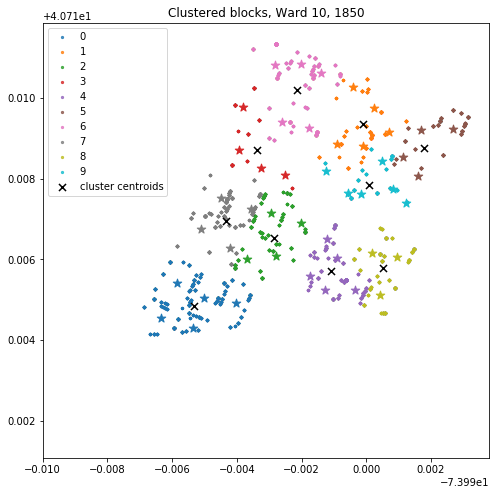

In [19]:
census_10 = filled_1850[filled_1850["Ward_Num"] == ward].copy()
cluster_mapping(census_10, block_cluster_map)
clustervis(census_10, ward, clusters, block_cluster_map, block_centroids, algo = algo)

In [256]:
census_10.cluster.value_counts()

2    2459
4    1896
1    1727
3    1499
5    1147
0     663
Name: cluster, dtype: int64

#### Try out predicting the cluster

This still doesn't work well. There are a couple things I would like to try
- adding in additional features from the dataset
- Using the entire dataset and unique block numbers, clustered (not sure how computationally feasible this is, to get any kind of granularity would need pretty small clusters)
- More features engineering

In [21]:
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import StratifiedShuffleSplit

In [36]:
census_1880.dropna(subset = ["block_num"], inplace = True)
filled_1850.rename(columns = {"Ward_Num":"WARD_NUM","cd_X":"CD_X", "cd_Y":"CD_Y"}, inplace = True)
dwellings_1850, dwellings_1880, census_1850_model, census_1880_model = interpolation.sequence_datasets(filled_1850, census_1880)

In [40]:
census_1850_model.rename(columns = {"WARD_NUM":"Ward_Num","CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)

In [41]:
census_1850_model_10 = census_1850_model[census_1850_model["Ward_Num"] == 10].copy()
cluster_mapping(census_1850_model_10, block_cluster_map)

In [51]:
#create train/test data
dwellings = census_1850_model_10.CENSUS_DWELLING_NUM.unique()
db = census_1850_model_10.loc[:,["CENSUS_DWELLING_NUM", 'cluster']].groupby("CENSUS_DWELLING_NUM", as_index = False).first().reset_index(drop = True).copy()
for train, test in StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 123).split(db["CENSUS_DWELLING_NUM"], db["cluster"]):
    train_dwellings = db.loc[train, "CENSUS_DWELLING_NUM"]
train = census_1850_model_10[census_1850_model_10["CENSUS_DWELLING_NUM"].isin(list(train_dwellings))].copy()
test = census_1850_model_10[~census_1850_model_10["CENSUS_DWELLING_NUM"].isin(list(train_dwellings))].copy()

In [76]:
train.columns

Index(['block_num', 'CD_ADDRESS', 'cd_X', 'cd_Y', 'CENSUS_AGE', 'CENSUS_CITY',
       'CENSUS_DWELLING_NUM', 'CENSUS_DWELLING_SEQ', 'CENSUS_DWELLING_SIZE',
       'CENSUS_GEOG', 'CENSUS_HH_NUM', 'CENSUS_ID', 'CENSUS_IMPREL',
       'CENSUS_INDEX', 'CENSUS_IPUMS_UID', 'CENSUS_LABFORCE', 'CENSUS_LINE',
       'CENSUS_MARST', 'CENSUS_NAMEFRST', 'CENSUS_NAMELAST', 'CENSUS_OCCSTR',
       'CENSUS_PAGENUM', 'CENSUS_PLACE', 'CENSUS_RACEB', 'CENSUS_REEL',
       'CENSUS_SEQ_NUM', 'CENSUS_SERIALB', 'CENSUS_SEXB', 'Ward_Num',
       'selected', 'spatial_weight', 'spatial_weight_sum', 'sequence_id',
       'sequence_order', 'num_between', 'sequence_order_enum', 'house_number',
       'street_name', 'cluster'],
      dtype='object')

In [75]:
#Run ridge model
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE", "sequence_order", "sequence_order_enum" ,"CENSUS_SEQ_NUM", "CNSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", "CENSUS_ID", "sequence_order_enum"]
target_encode = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE", "sequence_order", "sequence_order_enum" ,"CENSUS_SEQ_NUM", "CNSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", "CENSUS_ID"]
pp = make_column_transformer((TargetEncoder(cols = target_encode), target_encode), remainder = "passthrough")
block_class = Pipeline([('preprocess', pp),
                         ('classifier', RidgeClassifier())])
block_class.fit(train.loc[:,all_cols], train.loc[:,"cluster"])
print("Model Trained for Ward " + str(ward))
print("Training Score:", block_class.score(train.loc[:,all_cols], train.loc[:,"cluster"]))
print("1850 Test Score:", block_class.score(test.loc[:,all_cols], test.loc[:,"cluster"]), "\n")

ValueError: Selected columns, ['CENSUS_SERIALB', 'CENSUS_AGE', 'CENSUS_PAGENUM', 'CENSUS_SEXB', 'CENSUS_RACEB', 'sequence_id', 'CENSUS_DWELLING_SIZE', 'sequence_order', 'sequence_order_enum', 'CENSUS_SEQ_NUM', 'CNSUS_LABFORCE', 'CENSUS_LINE', 'CENSUS_MARST', 'CENSUS_NAMEFRST', 'CENSUS_NAMELAST', 'CENSUS_OCCSTR', 'CENSUS_IMPREL', 'CENSUS_ID'], are not unique in dataframe

In [45]:
#Run xgboost model
from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [306]:
train.loc[:,all_cols].head()

,CENSUS_SERIALB,CENSUS_AGE,CENSUS_REEL,CENSUS_PAGENUM,CENSUS_SEXB,CENSUS_RACEB,sequence_id,CENSUS_DWELLING_SIZE,sequence_order
129024,2085901,42,545,60,1,120,3788.0,7,2.0
129025,2085901,32,545,60,2,120,3788.0,7,2.0
129026,2085901,10,545,60,2,120,3788.0,7,2.0
129027,2085901,7,545,60,1,120,3788.0,7,2.0
129028,2085901,23,545,60,2,120,3788.0,7,2.0


So I tried several different parameters, tried different features, but none of it made a difference to the test score. And different preprocessing didn't help 

In [64]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE", "sequence_order"]
one_hot_encode = ["CENSUS_SEXB", "CENSUS_RACEB"]
target_encode = ["CENSUS_SERIALB", "sequence_id", "CENSUS_PAGENUM", "CENSUS_AGE",  "CENSUS_DWELLING_SIZE", "sequence_order"]

In [74]:
#note this seems really 
#all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_REEL", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE", "sequence_order", "CENSUS_SEQ_NUM", "CNSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", "CENSUS_ID"]
pp = make_column_transformer((TargetEncoder(cols = target_encode), target_encode), remainder = "passthrough")
block_class = Pipeline([('preprocess', TargetEncoder(cols = target_encode)),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 1, n_estimators = 80))])
block_class.fit(train.loc[:,all_cols], train.loc[:,"cluster"])
print("Model Trained for Ward 10")
print("Training Score:", block_class.score(train.loc[:,all_cols], train.loc[:,"cluster"]))
print("1850 Test Score:", block_class.score(test.loc[:,all_cols], test.loc[:,"cluster"]))

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


ValueError: feature_names must be unique

In [185]:
import hdbscan

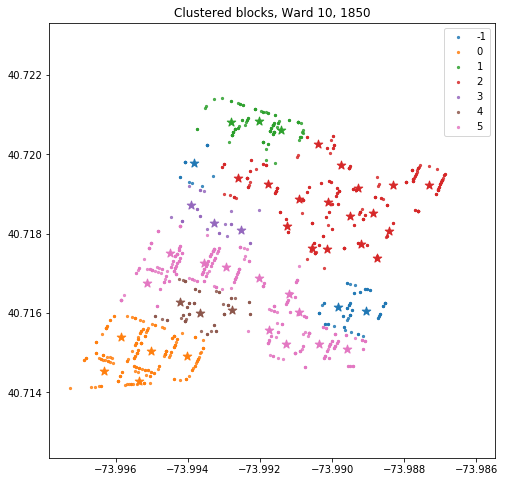

In [246]:
algo = hdbscan.HDBSCAN(min_cluster_size=3, min_samples = 1)
clusters, block_cluster_map = apply_clustering(cd_1850_10, ward, block_centroids, algo)
cluster_mapping(cd_1850_10, block_cluster_map)
clustervis(cd_1850_10, ward, clusters, block_cluster_map, block_centroids)

In [247]:
cd_1850_10.cluster.value_counts()

 5    366
 2    272
 0    207
 1    112
-1     83
 4     60
 3     23
Name: cluster, dtype: int64

In [248]:
print("cluster, count")
for cluster, count in zip(np.unique(clusters, return_counts = True)[0], np.unique(clusters, return_counts = True)[1]):
    print(cluster, ": ", count, sep = "")

cluster, count
-1: 3
0: 5
1: 3
2: 17
3: 3
4: 3
5: 11


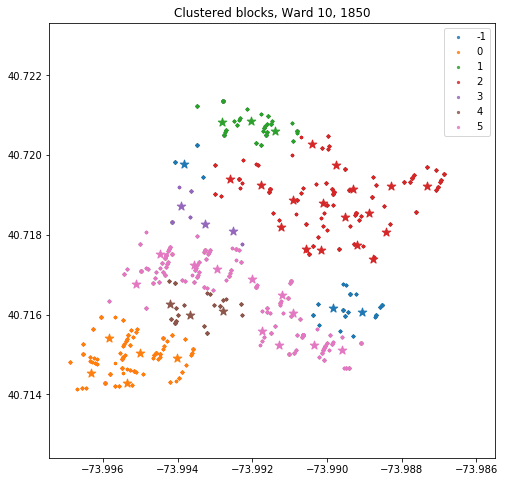

In [250]:
cluster_mapping(census_10, block_cluster_map)
clustervis(census_10, ward, clusters, block_cluster_map, block_centroids)

In [251]:
census_10.cluster.value_counts()

 5    3155
 2    2282
 0    1727
 1     894
-1     666
 4     530
 3     137
Name: cluster, dtype: int64

I'd think that kmeans would work better based on the visualizations, but testing is probably a good idea. I also want to get a sense of how low I can go so to speak, in terms of how small of clusters work for classification. First let's try these relatively large clusters and see what things look like